In [1]:
import numpy as np
import pandas as pd
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,roc_auc_score,confusion_matrix,precision_score,classification_report
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle

In [2]:
# Load dataset

dir = "./heart+disease/processed.switzerland.data"

columns = [
  'age', 'sex', 'cp', 'trestbps', 'chol',
  'fbs', 'restecg', 'thalach', 'exang', 'oldpeak',
  'slope', 'ca', 'thal', 'num'
]

# Read dataset
df = pd.read_csv(dir, names=columns, header=None)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,32,1,1,95,0,?,0,127,0,.7,1,?,?,1
1,34,1,4,115,0,?,?,154,0,.2,1,?,?,1
2,35,1,4,?,0,?,0,130,1,?,?,?,7,3
3,36,1,4,110,0,?,0,125,1,1,2,?,6,1
4,38,0,4,105,0,?,0,166,0,2.8,1,?,?,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       123 non-null    int64 
 1   sex       123 non-null    int64 
 2   cp        123 non-null    int64 
 3   trestbps  123 non-null    object
 4   chol      123 non-null    int64 
 5   fbs       123 non-null    object
 6   restecg   123 non-null    object
 7   thalach   123 non-null    object
 8   exang     123 non-null    object
 9   oldpeak   123 non-null    object
 10  slope     123 non-null    object
 11  ca        123 non-null    object
 12  thal      123 non-null    object
 13  num       123 non-null    int64 
dtypes: int64(5), object(9)
memory usage: 13.6+ KB


In [4]:
# Melihat data unique
cols = df.columns

for col in cols:
    print(f"Kolom {col}")
    print(df[col].value_counts())
    print("\n")

Kolom age
age
61    9
56    8
53    8
51    7
62    7
38    6
60    6
57    6
63    5
59    5
50    4
52    4
65    4
55    4
47    4
54    3
43    3
58    3
64    3
46    2
66    2
68    2
42    2
69    2
70    2
67    1
72    1
73    1
32    1
34    1
48    1
45    1
41    1
40    1
36    1
35    1
74    1
Name: count, dtype: int64


Kolom sex
sex
1    113
0     10
Name: count, dtype: int64


Kolom cp
cp
4    98
3    17
1     4
2     4
Name: count, dtype: int64


Kolom trestbps
trestbps
115    14
120    13
160    11
140    10
130    10
110    10
125     8
150     7
145     6
95      6
135     6
105     5
155     4
100     4
?       2
200     2
165     1
80      1
180     1
170     1
185     1
Name: count, dtype: int64


Kolom chol
chol
0    123
Name: count, dtype: int64


Kolom fbs
fbs
?    75
0    43
1     5
Name: count, dtype: int64


Kolom restecg
restecg
0    85
1    30
2     7
?     1
Name: count, dtype: int64


Kolom thalach
thalach
120    9
128    5
110    4
115    4
122    4


In [5]:
df.replace('?', np.nan, inplace=True)

In [6]:
df.isnull().sum()

age           0
sex           0
cp            0
trestbps      2
chol          0
fbs          75
restecg       1
thalach       1
exang         1
oldpeak       6
slope        17
ca          118
thal         52
num           0
dtype: int64

In [7]:
numMissVal = "trestbps"
catMissVal = ["fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]

# Handling missing value pada numerical data
df[numMissVal] = df[numMissVal].fillna(df[numMissVal].median())

# Handiling missing value pada categorical data
for col in catMissVal:
    df[col] = df[col].fillna(df[col].mode()[0])


In [8]:
# Melihat data unique
cols = df.columns

for col in cols:
    print(f"Kolom {col}")
    print(df[col].unique())
    print("\n")

Kolom age
[32 34 35 36 38 40 41 42 43 45 46 47 48 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 72 73 74]


Kolom sex
[1 0]


Kolom cp
[1 4 3 2]


Kolom trestbps
['95' '115' 125.0 '110' '105' '100' '135' '150' '125' '145' '140' '155'
 '160' '120' '130' '165' '80' '180' '170' '200' '185']


Kolom chol
[0]


Kolom fbs
['0' '1']


Kolom restecg
['0' '1' '2']


Kolom thalach
['127' '154' '130' '125' '166' '156' '179' '128' '150' '120' '144' '176'
 '99' '122' '145' '140' '138' '133' '113' '118' '149' '124' '110' '139'
 '92' '104' '170' '163' '60' '126' '82' '95' '115' '135' '141' '155' '83'
 '97' '98' '100' '148' '103' '121' '131' '182' '105' '175' '94' '119'
 '143' '63' '70' '77' '117' '123' '134' '72' '78' '109' '86' '114' '93'
 '67' '90' '108' '136' '157']


Kolom exang
['0' '1']


Kolom oldpeak
['.7' '.2' '0' '1' '2.8' '-1.1' '1.6' '-1.5' '1.5' '2' '.5' '-.1' '-2.6'
 '2.1' '-.7' '2.2' '3' '.1' '.3' '-2' '-1' '1.8' '1.4' '2.6' '.9' '2.4'
 '1.1' '.4' '2.5' '1.7' '-.8' '-

In [9]:
df = df.astype(float)

In [10]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,32.0,1.0,1.0,95.0,0.0,0.0,0.0,127.0,0.0,0.7,1.0,2.0,7.0,1.0
1,34.0,1.0,4.0,115.0,0.0,0.0,0.0,154.0,0.0,0.2,1.0,2.0,7.0,1.0
2,35.0,1.0,4.0,125.0,0.0,0.0,0.0,130.0,1.0,0.0,2.0,2.0,7.0,3.0
3,36.0,1.0,4.0,110.0,0.0,0.0,0.0,125.0,1.0,1.0,2.0,2.0,6.0,1.0
4,38.0,0.0,4.0,105.0,0.0,0.0,0.0,166.0,0.0,2.8,1.0,2.0,7.0,2.0


In [11]:
df.to_csv("clean_df.csv", index=False)

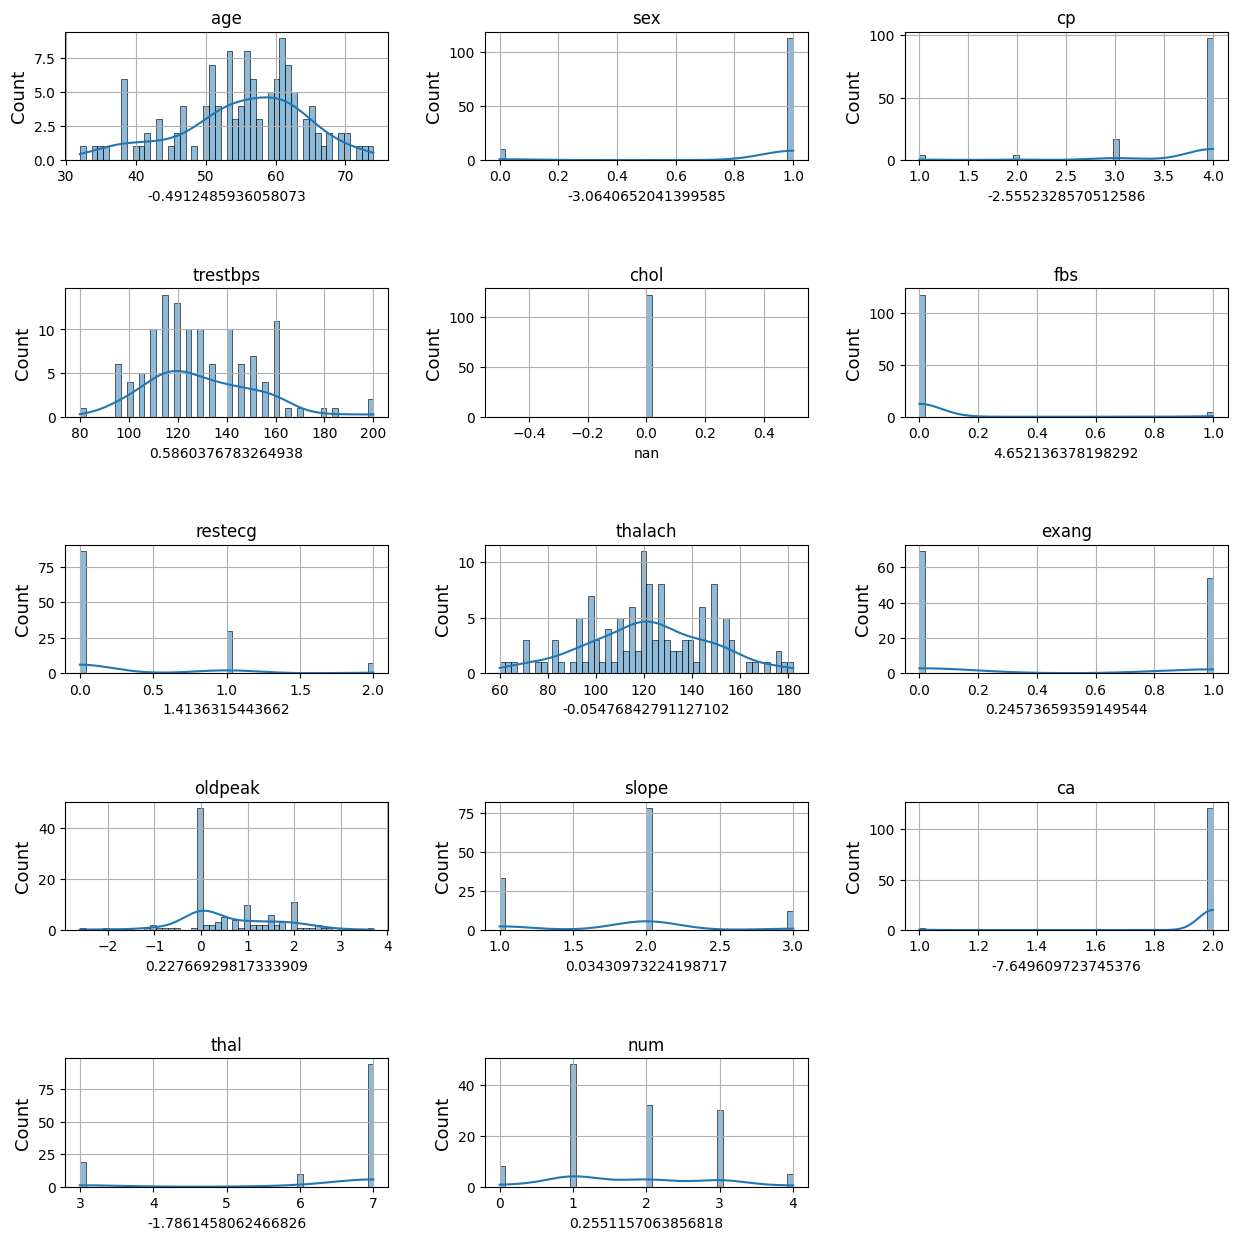

In [12]:
cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.figure(figsize=(15,15))

for i, col in enumerate(cols):
    plt.subplot(5,3,i+1)
    plt.xlabel(f'{skew(df[col])}')
    plt.ylabel("Count", fontsize=13)
    plt.subplots_adjust(hspace=1, wspace=0.3)
    plt.grid(True)
    plt.title(col)
    sns.histplot(data=df, x=col, bins=50, kde=True)

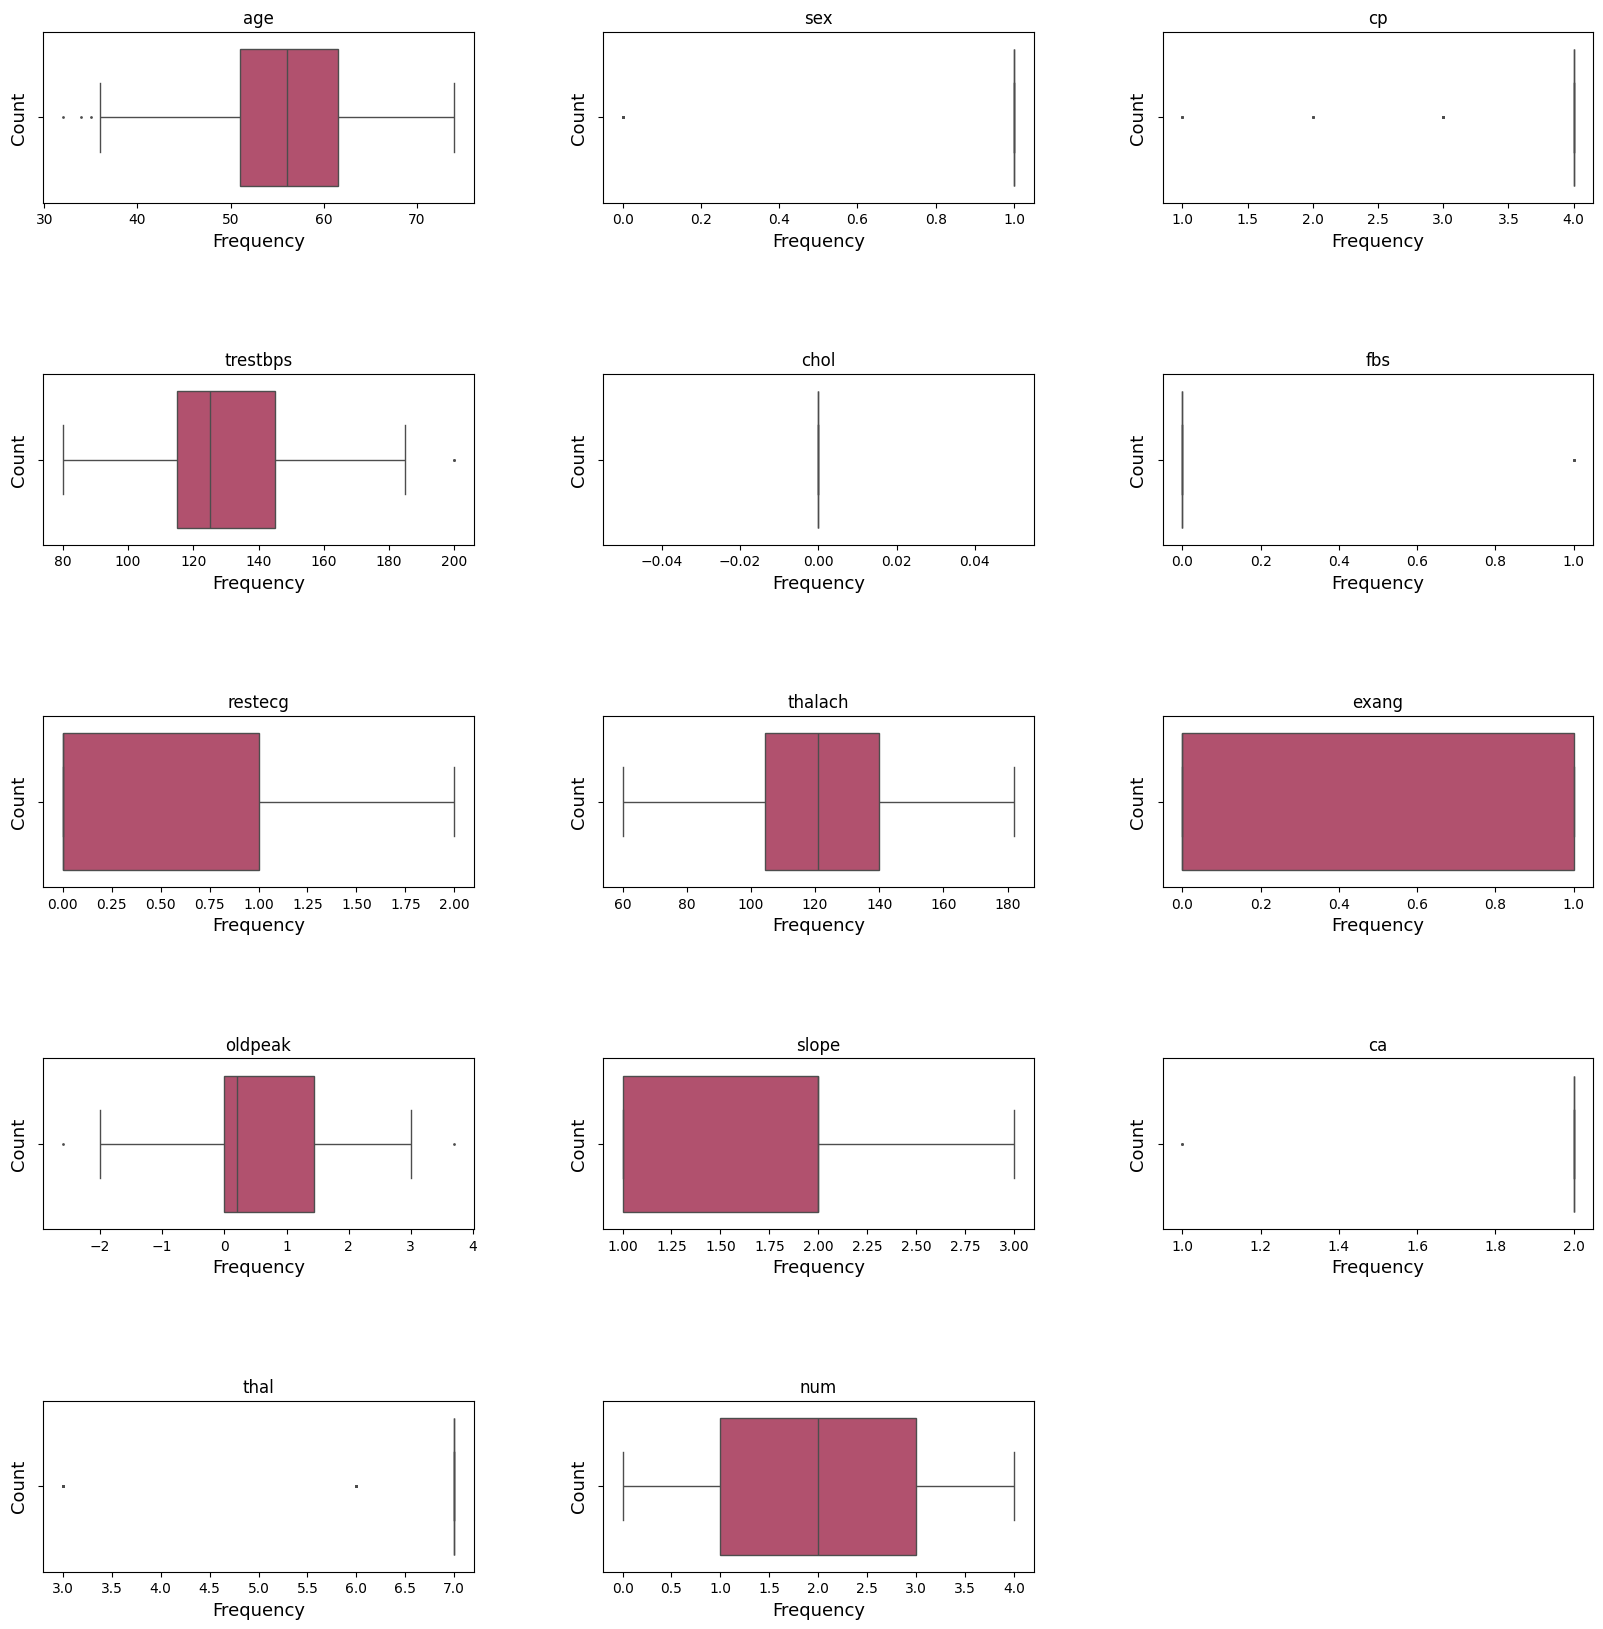

In [13]:
cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
plt.figure(figsize=(20,20))
for i, col in enumerate(cols):
    plt.subplot(5,3,i+1)
    plt.title(col)
    plt.xlabel('Frequency', fontsize=13)
    plt.ylabel("Count", fontsize=13)
    plt.subplots_adjust(hspace=1, wspace=0.3)
    sns.boxplot(data=df, x=col, palette='flare', fliersize=1)

<Axes: >

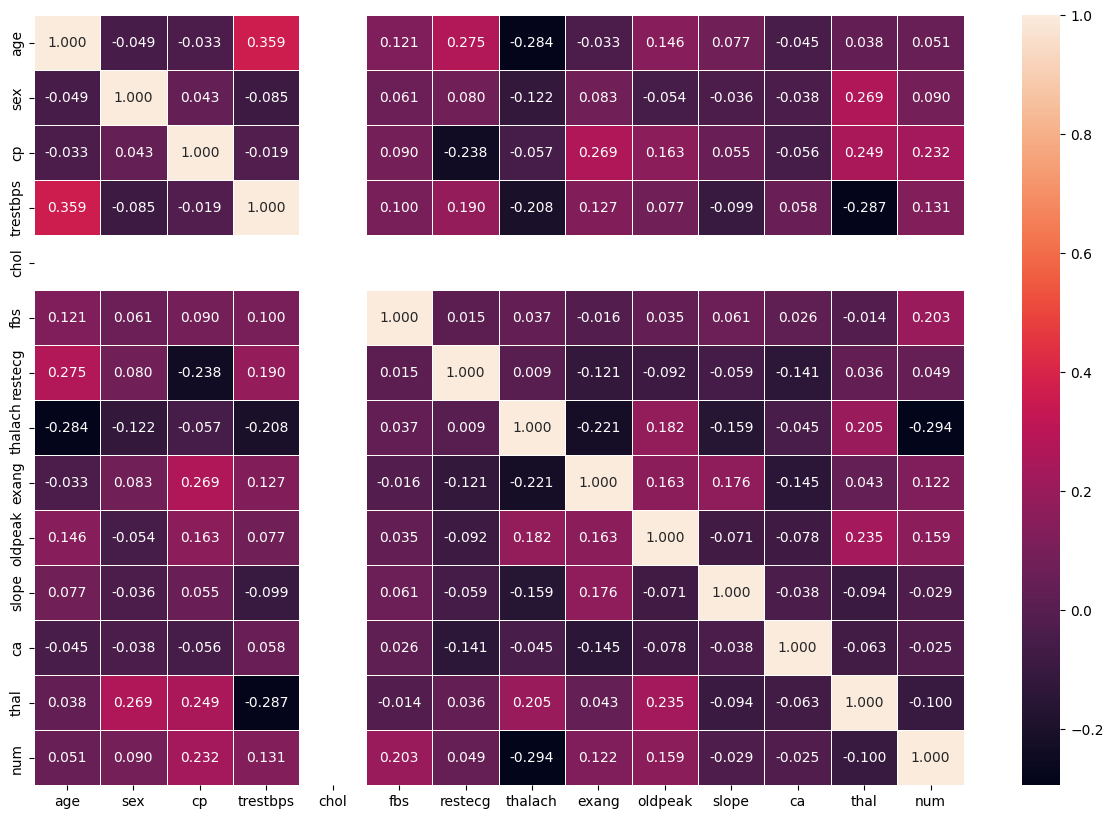

In [14]:
cor_mat=df.corr()
fig,ax=plt.subplots(figsize=(15,10))
sns.heatmap(cor_mat,annot=True,linewidths=0.5,fmt=".3f")

In [15]:
df["chol"].value_counts()

chol
0.0    123
Name: count, dtype: int64

In [16]:
df.drop(['fbs', 'ca', 'thal', "chol"], axis=1, inplace=True)

In [17]:
df.head()

,age,sex,cp,trestbps,restecg,thalach,exang,oldpeak,slope,num
0,32.0,1.0,1.0,95.0,0.0,127.0,0.0,0.7,1.0,1.0
1,34.0,1.0,4.0,115.0,0.0,154.0,0.0,0.2,1.0,1.0
2,35.0,1.0,4.0,125.0,0.0,130.0,1.0,0.0,2.0,3.0
3,36.0,1.0,4.0,110.0,0.0,125.0,1.0,1.0,2.0,1.0
4,38.0,0.0,4.0,105.0,0.0,166.0,0.0,2.8,1.0,2.0


<Axes: >

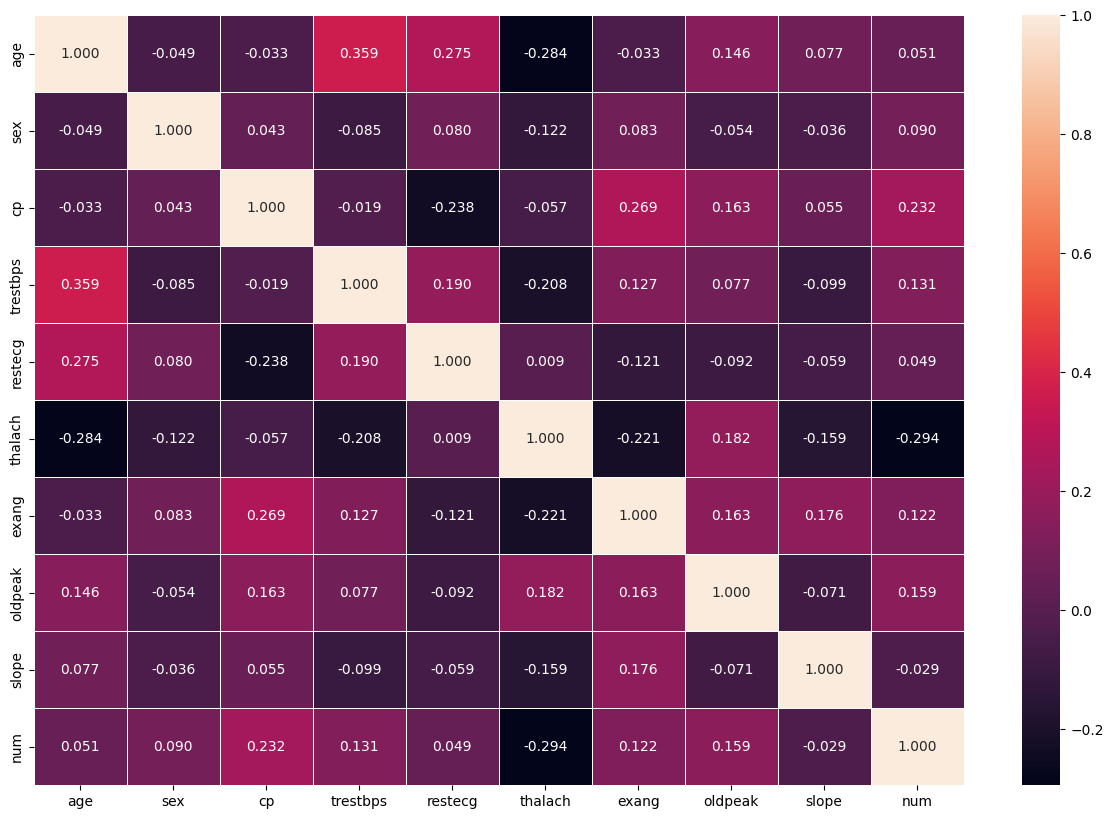

In [18]:
cor_mat=df.corr()
fig,ax=plt.subplots(figsize=(15,10))
sns.heatmap(cor_mat,annot=True,linewidths=0.5,fmt=".3f")

In [19]:
# Target variable independen sebagai y dan dependen sebagai X
X = df.drop("num", axis=1)
y = df.iloc[:,-1]

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '0.0'),
  Text(4, 0, '4.0')])

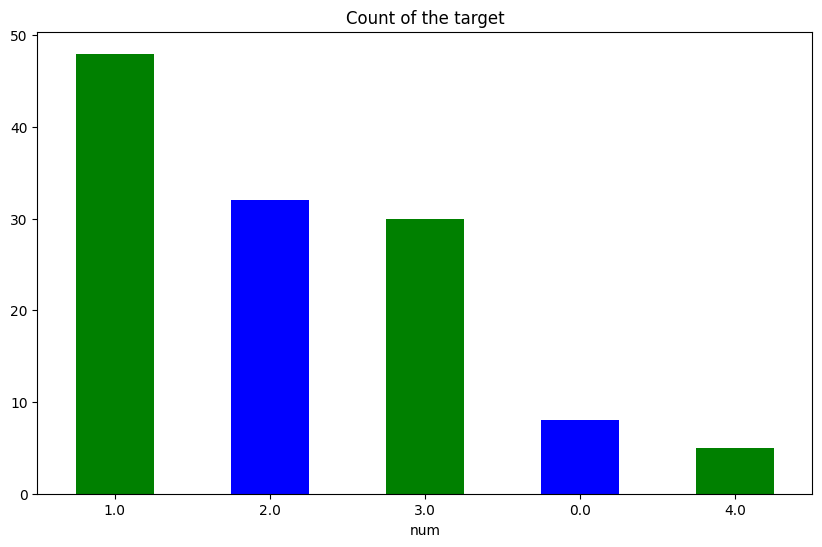

In [20]:
# Melihat jumlah variable target
df['num'].value_counts().plot(kind='bar',figsize=(10,6),color=['green','blue'])
plt.title("Count of the target")
plt.xticks(rotation=0)

In [26]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [27]:
# Standarisasi
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
def train_model(model, X_training, y_training, X_testing, modelName, y_testing, methodName):
    model.fit(X_training,y_training)
    y_pred = model.predict(X_testing)

    # Evaluate model
    print(f"{modelName} Model")
    acc = round(accuracy_score(y_testing, y_pred), 3)
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_testing, y_pred))

    #Confussion_matrix
    cm = confusion_matrix(y_testing, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix {modelName}')
    plt.xlabel('True')
    plt.ylabel('Predict')
    plt.show()

    print("\n")
    if (acc > 0.9):
    # Save the model using pickle
        with open(f"{modelName}_model_{methodName}.pkl", "wb") as model_file:
            pickle.dump(model, model_file)

In [29]:
knn_model = KNeighborsClassifier(n_neighbors=3)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=42)

K-Nearest Neighbors (KNN) Model
Accuracy: 0.452
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.64      0.60      0.62        15
         2.0       0.17      0.12      0.14         8
         3.0       0.57      0.57      0.57         7
         4.0       0.00      0.00      0.00         1

    accuracy                           0.45        31
   macro avg       0.28      0.26      0.27        31
weighted avg       0.48      0.45      0.47        31



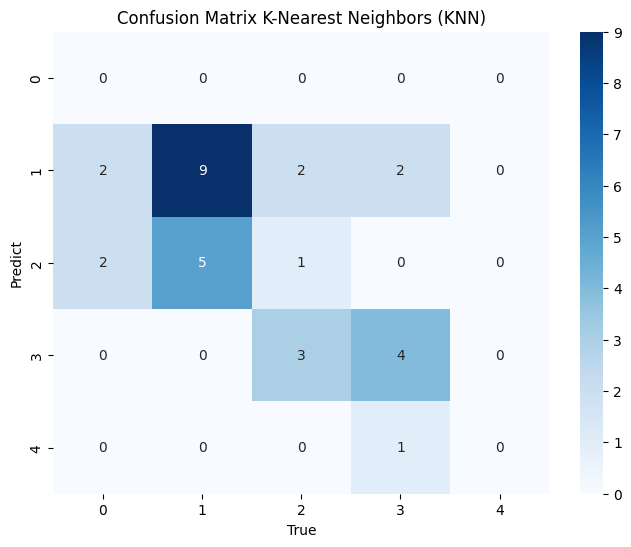

In [30]:
## KNN ##
nameModel = "K-Nearest Neighbors (KNN)"
nonRes_method = "Non Resampling"
# Model tidak resampling dan tidak normalisasi
train_model(knn_model, X_train, y_train, X_test, nameModel, y_test, nonRes_method)